In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

## Load Training Data

In [2]:
train_dataset = pd.read_csv("/Users/andreasalinetti/Documents/HACK4SDS/Dataset_DAY1/Data/train_set.csv", delimiter=';')

In [3]:
train_dataset.head() 

,application_ID,decision_date,company_ID,external_score_ver01,external_score_ver02,late_payment_score,external_score_late_payment_integrated,external_score_moderate,external_score_adverse,external_score_ver03,...,avg_count_enti_affidanti,std_count_enti_affidanti,max_count_enti_affidanti,last_count_enti_affidanti,avg_count_numero_prima_info,std_count_numero_prima_info,max_count_numero_prima_info,last_count_numero_prima_info,days_to_default,target
0,a1Q7R00000ej2yjUAA,2021-11-30,7256587870,10,3,NaN,NaN,NaN,NaN,MISSING,...,1,0,1,1,0,0,0,0,522,1
1,a1Q2X00000ZWC5LUAX,2020-10-06,6178307100,7,3,NaN,NaN,NaN,NaN,H,...,1,0,1,1,2,0,2,2,1498,0
2,a1Q2X00000XcCCQUA3,2020-02-11,7692855390,7,3,NaN,NaN,NaN,NaN,MISSING,...,1,0,1,1,1,0,1,1,779,1
3,a1Q7R00000ejSs3UAE,2022-01-18,5752241730,8,2,NaN,NaN,NaN,NaN,MISSING,...,1,0,1,1,"0,5","0,522232967867094",1,0,1498,0
4,a1Q7R00000eiRidUAE,2021-09-16,7533506540,4,1,NaN,NaN,NaN,NaN,MISSING,...,0,0,0,0,0,0,0,0,1498,0


## Analizing Data

In [4]:
import seaborn as sns

In [5]:
train_dataset.describe()

,external_score_ver01,external_score_ver02,late_payment_score,external_score_late_payment_integrated,external_score_moderate,external_score_adverse,age,last_statement_age,max_count_enti_affidanti,last_count_enti_affidanti,max_count_numero_prima_info,last_count_numero_prima_info,days_to_default,target
count,32032.000000,32032.000000,4544.000000,4544.000000,4824.000000,4824.000000,32032.000000,32032.000000,32032.000000,32032.000000,32032.000000,32032.000000,32032.000000,32032.000000
mean,6.772040,1.942433,9.286532,5.891505,6.039594,6.168947,8.972715,1.824894,2.928571,2.691964,1.146354,0.976773,1281.800356,0.215222
std,1.764166,0.786342,2.760645,1.244978,1.302913,1.343487,9.003956,0.621009,3.321439,3.105271,1.494643,1.314287,426.997217,0.410983
min,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,6.000000,1.000000,7.000000,5.000000,5.000000,5.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1498.000000,0.000000
50%,6.000000,2.000000,9.000000,6.000000,6.000000,6.000000,6.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1498.000000,0.000000
75%,8.000000,3.000000,10.000000,7.000000,7.000000,7.000000,11.000000,2.000000,4.000000,4.000000,2.000000,1.000000,1498.000000,0.000000
max,10.000000,3.000000,20.000000,10.000000,10.000000,10.000000,106.000000,7.000000,50.000000,45.000000,12.000000,12.000000,1498.000000,1.000000


In [6]:
#train_dataset.values.sum()

<Axes: xlabel='external_score_ver03', ylabel='count'>

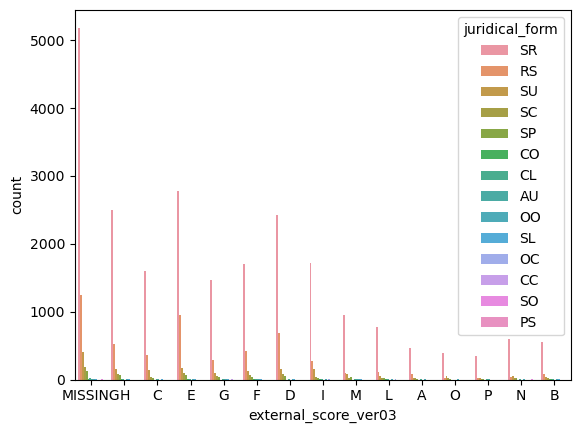

In [7]:
sns.countplot(x='external_score_ver03', hue= 'juridical_form', data= train_dataset)

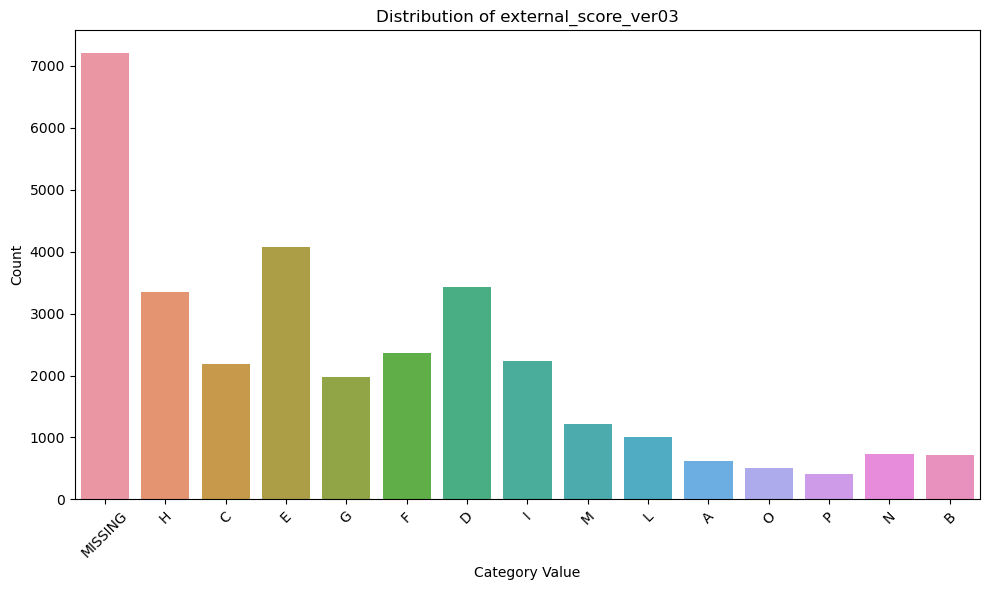

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# df = pd.read_csv("your_dataset.csv")

# Plot the distribution using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=train_dataset, x='external_score_ver03')
plt.xlabel('Category Value')
plt.ylabel('Count')
plt.title('Distribution of external_score_ver03')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

## <font color="yellow"> Clean and encode Data

#### Drop unneeded columns

In [9]:
## drop features
def Drop_unneed_columns(test, dataset):
    cols= ['days_to_default', 'application_ID', 'decision_date', 'company_ID']
    if test:
        cols.remove('days_to_default')
        dataset= dataset.drop(columns=cols)
    else:
        dataset= dataset.drop(columns=cols)
    return dataset


#### Find columns with to many Nan's values

In [10]:
def Nan_values(dataset):
    column_names = dataset.columns.tolist()
    drop_columns = []
    for name in column_names:
        nan_count = dataset[name].isna().sum()
        print(f"column {name}: {nan_count}")
        if (nan_count/28000) > 0.5:
            print(f"Number of NaN values in column '{name}': {nan_count}")
            drop_columns.append(name)
    return drop_columns

#### Label enconding

In [11]:
def Replace_cate_to_value(column_name, dataset):
    # Extract categories

    # Extract unique category names from the column
    unique_categories = dataset[column_name].unique()

    # convert 'numpy.ndarray' in to a python list
    l = unique_categories.tolist()
    
    if 'MISSING' in l:
        l.remove('MISSING')
        l.sort(reverse=True)
    # print(unique_categories)

    # print(f"remove{l}")
    dic = { l[i]:i+1 for i in range(0, len(l))}

    # dic = {}

    # for name in unique_categories:
    #     if name != "MISSING":
    #         dic{}
    # print(dic)

    # Replace values in the column based on the dictionary mapping
    dataset[column_name] = dataset[column_name].replace(dic)
    return dic, dataset

In [12]:
def Category_values(dataset):
    column_names = ['industry_sector', 'region', 'geo_area','external_score_ver03', 'province','juridical_form']
    dic = {}
    for column_name in column_names:
        category_dic, dataset = Replace_cate_to_value(column_name, dataset)
        dic[column_name] = category_dic
    return dic, dataset

#### Replace True and False values to numerical values in Columns

In [13]:
def Replace_bool_toNumbers(dataset):
    dataset['cr_available'] = [int(dataset['cr_available'][i]) for i in range(len(dataset['cr_available']))]
    dataset['cr_available']
    return dataset

#### Mean of external score var 03 

In [14]:
def mean_var03(dataset):
    s0, s1, c0, c1 = 0,0,0,0
    # unique_labels = dataset['target'].unique()
    for index, row in dataset.iterrows():
        if row['external_score_ver03'] != 'MISSING':
            if row['target'] == 0:
                s0 += row['external_score_ver03']
                c0 +=1
            elif row['target'] == 1:
                s1 +=  row['external_score_ver03']
                c1 += 1

    m0 = round(s0/c0)
    m1 = round(s1/c1)
    print(m0)
    print(m1)
    return m0,m1


#### Replace MISSING values to Mean finded 

In [15]:
def Replace_missing(dataset, m0, m1):
    # Assuming df is your DataFrame and 'column_to_change' is the column you want to change
    # 'condition_column' is the column based on which you want to change the content
    dataset.loc[(dataset['target'] == 1) & (dataset['external_score_ver03'] == 'MISSING'), 'external_score_ver03'] = m1
    dataset.loc[(dataset['target'] == 0) & (dataset['external_score_ver03'] == 'MISSING'), 'external_score_ver03'] = m0
    dataset['external_score_ver03']

    # For example, if you want to change the content of 'column_to_change' to 'new_value' where 'condition_column' is True
    # Replace 'new_value', 'column_to_change', and 'condition_column' with your actual values
    return dataset

## <font color="green"> Main code for train dataset 

In [16]:
# Drop columns 
train_dataset = Drop_unneed_columns(False,train_dataset)
drop_columns = Nan_values(train_dataset)
train_dataset = train_dataset.drop(columns=drop_columns)



column external_score_ver01: 0
column external_score_ver02: 0
column late_payment_score: 27488
Number of NaN values in column 'late_payment_score': 27488
column external_score_late_payment_integrated: 27488
Number of NaN values in column 'external_score_late_payment_integrated': 27488
column external_score_moderate: 27208
Number of NaN values in column 'external_score_moderate': 27208
column external_score_adverse: 27208
Number of NaN values in column 'external_score_adverse': 27208
column external_score_ver03: 0
column age: 0
column province: 2654
column juridical_form: 0
column industry_sector: 0
column gross_margin_ratio: 0
column core_income_ratio: 0
column cash_asset_ratio: 0
column consolidated_liabilities_ratio: 0
column tangible_assets_ratio: 0
column revenues: 0
column cr_available: 0
column region: 0
column geo_area: 0
column last_statement_age: 0
column overrun_freq_a_revoca_autoliquidanti: 0
column avg_tension_a_revoca_autoliquidanti: 0
column std_tension_a_revoca_autoliqui

In [17]:
# replace bool values to numerical ones 
category_dics, train_dataset = Category_values(train_dataset)
train_dataset = Replace_bool_toNumbers(train_dataset)


In [18]:
# v03 column with missing values 
m0, m1= mean_var03(train_dataset)
train_dataset = Replace_missing(train_dataset, m0, m1)

8
10


## <font color="yellow"> Normalise Datase

#### Replace the "," to ".", in such a way to pass from object to number

In [19]:
def normalized_data(dataset):
    # Replace commas with periods in all columns
    dataset = dataset.replace(',', '.', regex=True)
    print(dataset.dtypes)
    dataset = dataset.astype('float32')

    # check if the dataset has any nan value
    has_nan_values = dataset.isna().any().any()

    if has_nan_values:
        print("DataFrame contains NaN values.")
    else:
        print("DataFrame does not contain any NaN values.")

    return dataset

#### Normalise Columns

## <font color="green"> Main code Normalise Dataset

In [20]:
train_dataset = normalized_data(train_dataset)

external_score_ver01                      int64
external_score_ver02                      int64
external_score_ver03                      int64
age                                       int64
province                                  int64
juridical_form                            int64
industry_sector                           int64
gross_margin_ratio                       object
core_income_ratio                        object
cash_asset_ratio                         object
consolidated_liabilities_ratio           object
tangible_assets_ratio                    object
revenues                                 object
cr_available                              int64
region                                    int64
geo_area                                  int64
last_statement_age                        int64
overrun_freq_a_revoca_autoliquidanti     object
avg_tension_a_revoca_autoliquidanti      object
std_tension_a_revoca_autoliquidanti      object
max_tension_a_revoca_autoliquidanti     

In [21]:
pd.set_option('display.max_columns', None)
train_dataset.head(30)

,external_score_ver01,external_score_ver02,external_score_ver03,age,province,juridical_form,industry_sector,gross_margin_ratio,core_income_ratio,cash_asset_ratio,consolidated_liabilities_ratio,tangible_assets_ratio,revenues,cr_available,region,geo_area,last_statement_age,overrun_freq_a_revoca_autoliquidanti,avg_tension_a_revoca_autoliquidanti,std_tension_a_revoca_autoliquidanti,max_tension_a_revoca_autoliquidanti,last_tension_a_revoca_autoliquidanti,avg_rel_used_a_revoca_autoliquidanti,std_rel_used_a_revoca_autoliquidanti,max_rel_used_a_revoca_autoliquidanti,last_rel_used_a_revoca_autoliquidanti,overrun_freq_a_scadenza,avg_rel_used_a_scadenza,std_rel_used_a_scadenza,max_rel_used_a_scadenza,last_rel_used_a_scadenza,avg_count_enti_affidanti,std_count_enti_affidanti,max_count_enti_affidanti,last_count_enti_affidanti,avg_count_numero_prima_info,std_count_numero_prima_info,max_count_numero_prima_info,last_count_numero_prima_info,target
0,10.0,3.0,10.0,15.0,1.0,1.0,1.0,0.464637,0.012593,0.000000,0.416002,1.000000,410.0,1.0,1.0,1.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.176975,2.111932e-03,0.179073,0.172032,1.000000,0.000000,1.0,1.0,0.000000,0.000000,0.0,0.0,1.0
1,7.0,3.0,7.0,5.0,2.0,2.0,2.0,0.372340,0.115385,0.235955,0.484043,1.000000,208.0,1.0,2.0,1.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.151754,6.806286e-03,0.164755,0.146385,1.000000,0.000000,1.0,1.0,2.000000,0.000000,2.0,2.0,0.0
2,7.0,3.0,10.0,5.0,3.0,1.0,3.0,0.270000,0.006369,0.359375,0.125000,0.375000,471.0,0.0,3.0,2.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.0,1.0,1.000000,0.000000,1.0,1.0,1.0
3,8.0,2.0,8.0,6.0,4.0,1.0,1.0,0.419929,0.152174,0.136150,0.765125,0.058824,598.0,1.0,4.0,3.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025084,2.619898e-02,0.050167,0.050167,1.000000,0.000000,1.0,1.0,0.500000,0.522233,1.0,0.0,0.0
4,4.0,1.0,8.0,5.0,5.0,1.0,1.0,0.526316,0.083333,0.233333,0.197368,0.750000,108.0,0.0,5.0,4.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
5,6.0,1.0,12.0,2.0,6.0,1.0,4.0,0.673177,0.026609,0.192248,0.252604,0.504065,2073.0,1.0,6.0,5.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.060680,3.722236e-02,0.146051,0.146051,2.250000,0.452267,3.0,3.0,2.916667,0.668558,4.0,1.0,0.0
6,7.0,3.0,10.0,3.0,7.0,2.0,1.0,1.666667,0.017544,0.615385,0.277778,0.000000,57.0,0.0,7.0,2.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
7,6.0,1.0,10.0,9.0,8.0,1.0,5.0,0.307391,0.010648,0.080271,0.157611,0.843066,12209.0,1.0,8.0,5.0,3.0,0.000000,0.458545,0.248584,0.790275,0.202147,0.027610,0.013843,0.045343,0.012444,0.000000,0.020232,2.002530e-02,0.040953,0.037795,6.000000,0.000000,6.0,6.0,0.250000,0.621582,2.0,2.0,1.0
8,10.0,3.0,10.0,2.0,9.0,1.0,2.0,0.457291,0.068892,0.000000,0.369089,1.000000,584.0,1.0,9.0,2.0,2.0,0.083333,12637.000000,43775.539062,151643.000000,1.000000,0.002856,0.009886,0.034247,0.034247,0.000000,0.094279,4.360371e-04,0.095017,0.095017,1.000000,0.000000,1.0,1.0,1.000000,0.000000,1.0,1.0,1.0
9,7.0,2.0,8.0,12.0,10.0,3.0,6.0,0.221461,-0.045290,0.051724,0.081050,0.715017,552.0,0.0,10.0,2.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


## <font color="yellow"> Build a Balanced Dataset

In [22]:
def split_dataframe_by_label(df, label_column, label_value_1, label_value_2, sample_size):
    # Separate the DataFrame based on the labels
    subset_1 = df[df[label_column] == label_value_1]
    subset_2 = df[df[label_column] == label_value_2]
    
    # Take a random sample of rows from each subset
    subset_1_sampled = subset_1.sample(n=sample_size, random_state=42)
    subset_2_sampled = subset_2.sample(n=sample_size, random_state=42)
    
    # Concatenate the sampled subsets to form the final split
    final_split = pd.concat([subset_1_sampled, subset_2_sampled], ignore_index=True)

    return final_split

train_dataset = split_dataframe_by_label(train_dataset, 'target', 0, 1, 6894)
print(train_dataset.shape)

(13788, 40)


## <font color="yellow"> SVM Model

In [23]:
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [24]:
Y = train_dataset['target']

# Standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_dataset.drop(columns='target'))

# Create PCA object
pca = PCA(n_components=30)  # Specify the number of components (desired dimensionality)

# Fit PCA to the standardized data and transform the data
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, Y_train, Y_test = train_test_split(X_pca,Y, test_size=0.1, stratify=Y, random_state=2)

print(X_train.shape, X_test.shape)

# classifier = svm.SVC(C=0.1 ,kernel='linear', gamma=0.001, class_weight="balanced")
classifier = svm.SVC(C=0.1, kernel='linear', gamma='scale', class_weight='balanced', verbose=True)

classifier.fit(X_train, Y_train)

(12409, 30) (1379, 30)
[LibSVM].......................*....*...............*.....*
optimization finished, #iter = 45874
obj = -894.384189, rho = -0.005993
nSV = 8966, nBSV = 6001
Total nSV = 8966


SVC(C=0.1, class_weight='balanced', kernel='linear', verbose=True)

In [25]:
X_test_prediction = classifier.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction,Y_test)
print(test_data_accuracy)

0.6867295141406816


#### F1 Score SVM 

In [26]:
from sklearn.metrics import f1_score

# Assuming classifier is your trained SVM model and X_test, y_test are your test data
y_pred = classifier.predict(X_test)

# Calculate F1 score
f1 = f1_score(Y_test, y_pred)

print("F1 Score:", f1)

F1 Score: 0.6865021770682148


## <font color="yellow"> Random Forest 

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Split the dataset into features (X) and target variable (y)
X = train_dataset.drop(columns=['target'])  # Assuming 'target_column' is your target variable
y = train_dataset['target']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 4: Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Step 5: Evaluate the classifier on the testing data
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.7730239303843365


#### F1 Score

In [28]:
# Step 6: Compute the F1 score
f1 = f1_score(y_test, y_pred)
print(f1)

0.7728592162554427


## <font color="yellow"> Gaussian Naive Bayes

In [36]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

num_folds = 3
gnb_classifier = GaussianNB()

X = train_dataset.iloc[:, :-1].to_numpy()
y = train_dataset.iloc[:, -1].to_numpy()

kf = KFold(n_splits=num_folds, shuffle=True)

all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}/{num_folds}')

    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    gnb_classifier.fit(X_train, y_train)
    y_pred_fold = gnb_classifier.predict(X_train)
    all_predictions.append(y_pred_fold)
    print(y_pred_fold.shape)
    accuracy = accuracy_score(y_train, y_pred_fold)

#print(np.array(all_predictions).shape)
# Compute the average of all predictions while maintaining the shape
average_predictions = np.mean(np.array(all_predictions), axis=0).astype(int)
print(average_predictions.shape)

# Calculate the accuracy using the average predictions
accuracy = accuracy_score(y, average_predictions)
print("Accuracy:", accuracy)


Fold 1/3
(9192,)
Fold 2/3
(9192,)
Fold 3/3
(9192,)
(9192,)


ValueError: Found input variables with inconsistent numbers of samples: [13788, 9192]

In [ ]:
from sklearn.model_selection import cross_val_score

# Create the Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

# Perform 5-fold cross-validation
cv_scores = cross_val_score(gnb_classifier, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)

# Calculate and print the mean cross-validation score
mean_cv_score = cv_scores.mean()
print("Mean Cross-validation Score:", mean_cv_score)


Cross-validation Scores: [0.63669326 0.62907904 0.67367658 0.61080885 0.6314835 ]
Mean Cross-validation Score: 0.6363482445501634


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Split the dataset into features (X) and target variable (y)
X = train_dataset.drop(columns=['target'])  # Assuming 'target' is your target variable
y = train_dataset['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=39)  # Select top 20 features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Create the Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

# Train the classifier on the selected features
gnb_classifier.fit(X_train_selected, y_train)

# Make predictions on the testing data
y_pred = gnb_classifier.predict(X_test_selected)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6337926033357505


#### F1 Score 

In [ ]:
# Step 6: Compute the F1 score
f1 = f1_score(y_test, y_pred)
print(f1)

0.5874183006535947


## <font color="yellow"> KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create KNN classifier
k = 5  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', metric='manhattan')

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.65


#### F1 Score 

In [ ]:
# Step 6: Compute the F1 score
f1 = f1_score(y_test, y_pred)
print(f1)

0.6577181208053692


## <font color="yellow"> Prima Neural Network 

In [ ]:
# # Define the neural network architecture
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_size, 16)  
#         self.fc2 = nn.Linear(16,8)
#         self.relu = nn.ReLU()
#         self.fc3 = nn.Linear(8, 1)
#         self.dropout = nn.Dropout(p=0.2)
#         self.fc4 = nn.Linear(8, 1)  # Output layer with 1 neuron for binary classification

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc3(x)
#         x = self.relu(x)
#         #x = self.fc4(x)
#         return torch.sigmoid(x)



# accuracy_values = []
# loss_values = []
# X = train_dataset.iloc[:, :-1].to_numpy()
# y = train_dataset.iloc[:, -1].to_numpy()

# num_folds = 5
# input_size = 39
# num_epochs = 40
# num_models = 1

# kf = KFold(n_splits=num_folds, shuffle=True)

# criterion = nn.BCELoss() 
# l1_lambda = 0.01
# l2_lambda = 0.01
# fold_params = []

# for model_index in range(num_models):

#     for fold, (train_indices, val_indices) in enumerate(kf.split(X)):
#         print(f'Fold {fold+1}/{num_folds}')

#         #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

#         # Split the data into training and validation sets
#         X_train, X_val = X[train_indices], X[val_indices]
#         y_train, y_val = y[train_indices], y[val_indices]

#         # Convert data to PyTorch tensors
#         X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#         y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
#         X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
#         y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
        
#         model = NeuralNetwork(input_size)
#         optimizer = optim.Adam(model.parameters(), lr=0.001)
#         # Train the neural network

#         for epoch in range(num_epochs):
#             # Forward pass
#             outputs = model(X_train_tensor)
#             loss = criterion(outputs, y_train_tensor.view(-1, 1))
#             loss_values.append(loss.item())

#             l1_reg = torch.tensor(0., requires_grad=True)
#             for param in model.parameters():
#                 l1_reg = l1_reg + torch.norm(param, p=1)
#             loss = loss + l1_lambda * l1_reg

#             # L2 regularization
#             l2_reg = torch.tensor(0., requires_grad=True)
#             for param in model.parameters():
#                 l2_reg = l2_reg + torch.norm(param, p=2)
#             loss = loss + l2_lambda * l2_reg
            
#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         fold_params.append(model.state_dict())
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Fold:{fold}')

#         # Evaluate the model
#         with torch.no_grad():
#             # Predict probabilities on the test set
#             outputs = model(X_val_tensor)
#             predicted = (outputs >= 0.5).float()
            
#             # Calculate accuracy
#             accuracy = (predicted == y_val_tensor.view(-1, 1)).float().mean()
#             accuracy_values.append(accuracy)
#             print(f'Accuracy on test set: {accuracy.item()*100:.2f}%')
#     torch.save(model.state_dict(), f'model_{model_index}.pth')

# avg_params = {}

# for key in fold_params[0].keys():
#     avg_params[key] = torch.stack([params[key] for params in fold_params]).mean(dim=0)

# # Create a new model with the average parameters
# average_model = NeuralNetwork(input_size)
# average_model.load_state_dict(avg_params)
# print(f'Averagea ccuracy on test set: {np.array(accuracy_values).mean()*100:.2f}%')


#### Plot Loss Chart

In [ ]:
# import matplotlib.pyplot as plt

# # Plot the loss values
# plt.plot(loss_values, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Epochs')
# plt.legend()
# plt.grid(True)
# plt.show()

#### Calculated F1 score

In [ ]:
# from sklearn.metrics import f1_score

# true_labels = y_val_tensor.numpy().astype(int)
# predicted_labels = 1-(predicted.numpy())
# # Calculate F1 score
# f1 = f1_score(true_labels, predicted_labels)
# print(f'F1 score on test set: {f1:.4f}')

## <font color="yellow"> Test Dataset

In [ ]:
from sklearn.impute import SimpleImputer

#### Load Dataset

In [ ]:
test_dataset = pd.read_csv("/Users/andreasalinetti/Documents/HACK4SDS/Dataset_DAY1/Data/test_set.csv", delimiter=';')


In [ ]:
test_dataset.head()

,application_ID,decision_date,company_ID,external_score_ver01,external_score_ver02,late_payment_score,external_score_late_payment_integrated,external_score_moderate,external_score_adverse,external_score_ver03,age,province,juridical_form,industry_sector,gross_margin_ratio,core_income_ratio,cash_asset_ratio,consolidated_liabilities_ratio,tangible_assets_ratio,revenues,cr_available,region,geo_area,last_statement_age,overrun_freq_a_revoca_autoliquidanti,avg_tension_a_revoca_autoliquidanti,std_tension_a_revoca_autoliquidanti,max_tension_a_revoca_autoliquidanti,last_tension_a_revoca_autoliquidanti,avg_rel_used_a_revoca_autoliquidanti,std_rel_used_a_revoca_autoliquidanti,max_rel_used_a_revoca_autoliquidanti,last_rel_used_a_revoca_autoliquidanti,overrun_freq_a_scadenza,avg_rel_used_a_scadenza,std_rel_used_a_scadenza,max_rel_used_a_scadenza,last_rel_used_a_scadenza,avg_count_enti_affidanti,std_count_enti_affidanti,max_count_enti_affidanti,last_count_enti_affidanti,avg_count_numero_prima_info,std_count_numero_prima_info,max_count_numero_prima_info,last_count_numero_prima_info
0,a1Q7R00000ZWFXwUAP,2020-10-12,1321219660,5,1,8.0,5.0,6.0,7.0,D,6,PD,SR,Distribuzione,"0,0698090692124105","-0,0133630289532294","0,0454201362604088","0,39200477326969",1,449,True,Veneto,Nord-est,1,"0,166666666666667","0,554859166666667","0,146890245697462","0,83594","0,60264","0,123576651818857","0,032714976770036","0,186178173719376","0,134218262806236","0,333333333333333","1,27369933184855","0,028642038445761","1,32464142538975","1,32464142538975","1,16666666666667","0,389249472080761",2,2,"1,08333333333333","0,288675134594813",2,1
1,a1Q7R00000ZWJX2UAP,2020-11-12,1420617490,8,1,NaN,NaN,NaN,NaN,F,46,IS,SR,Altri beni di consumo,"0,169093471113199","0,00206611570247934","0,155359917141378","0,54062940347581","0,95959595959596",1402,False,Molise,Sud,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1
2,a1Q7R00000a3E9nUAE,2021-07-05,137667970,8,1,NaN,NaN,NaN,NaN,I,51,CB,SR,Chimica di base e intermedi,"0,0589433072553853","0,0306451612903226","0,0043021855102392","0,640767334690816","0,980113636363636",1254,True,Molise,Sud,2,"0,833333333333333","0,941108491613086","0,0992007690627971","1,0864",1,"0,137654704944179","0,115573259414523","0,267955342902711","0,0119617224880383",0,"0,212708532695375","0,100377623990215","0,33222009569378","0,320196172248804",3,0,3,3,"1,91666666666667","0,288675134594813",2,2
3,a1Q7R00000ZWRR6UAP,2021-01-19,137667970,8,1,NaN,NaN,NaN,NaN,F,51,CB,SR,Chimica di base e intermedi,"0,0589433072553853","0,0306451612903226","0,0043021855102392","0,640767334690816","0,980113636363636",1254,True,Molise,Sud,2,"0,833333333333333","0,878429123495436","0,0566505328975202","0,972473824531666","0,903049655802421","0,252491959064328","0,0249197649236005","0,269318979266348","0,17658293460925",0,"0,14559735513025","0,0113414597444539","0,162240829346092","0,126861244019139",3,0,3,3,"1,91666666666667","0,288675134594813",2,2
4,a1Q7R00000g6DWvUAM,2022-05-09,2412739090,6,1,NaN,NaN,NaN,NaN,F,72,SS,SR,Alimentare,"0,135170603674541","-0,0755467196819085","0,0169851380042463","0,492125984251969","0,769345238095238",1463,True,Sardegna,Isole,2,0,"0,722863999082564","0,0605656113993484","0,816631566033492","0,761046273164548","0,284641717931192","0,0245101240633782","0,315383458646616","0,306924812030075",0,"0,38485640236956","0,0307032798267901","0,478388926862611","0,356901572112098",3,0,3,3,"2,08333333333333","0,288675134594813",3,3


#### Preprocess Test Dataset

In [ ]:
# Drop columns 
test_dataset = Drop_unneed_columns(True,test_dataset)

test_dataset = test_dataset.drop(columns=drop_columns)

In [ ]:

category_dics["juridical_form"]["SS"] = 15
category_dics["juridical_form"]["OS"] = 16


In [ ]:
#print(category_dics["juridical_form"])
for k,v in category_dics.items():
    test_dataset.replace({k:v}, inplace=True)


In [ ]:
c = test_dataset["external_score_ver03"].value_counts()
# print(c)

In [ ]:
# find columns with MISSING values 
columns = []
for column in list(test_dataset.columns):
    # Check if there is a value "MISSING" in the 'column_name' column
    missing_values = test_dataset[column] == 'MISSING'

    # Check if any row contains the value "MISSING" in the specified column
    if missing_values.any():
        print(f"'MISSING' in the column: {column}")
        columns.append(column)
    

'MISSING' in the column: external_score_ver03
'MISSING' in the column: province
'MISSING' in the column: region
'MISSING' in the column: geo_area


In [ ]:
# Sum values in the specified columns
dic = {}
for column in columns:
    column_name = column

    count = 0
    sum_values = 0
    # Iterate over the DataFrame
    for index, row in test_dataset.iterrows():
        # Access the value of the specified column for each row
        count +=1
        if isinstance(row[column_name], str):
            continue
        elif isinstance(row[column_name], int):
            sum_values += row[column_name]
    
    dic[column] = int(sum_values/count)

print(dic)
       

{'external_score_ver03': 6, 'province': 31, 'region': 7, 'geo_area': 3}


In [ ]:
def Replace_missing_test(dataset,val, column):
    # Assuming df is your DataFrame and 'column_to_change' is the column you want to change
    # 'condition_column' is the column based on which you want to change the content
    dataset.loc[(dataset[column] == 'MISSING'), column] = val


    # For example, if you want to change the content of 'column_to_change' to 'new_value' where 'condition_column' is True
    # Replace 'new_value', 'column_to_change', and 'condition_column' with your actual values
    return dataset

In [ ]:
for k,v in dic.items():
    test_dataset = Replace_missing_test(test_dataset,v,k)

In [ ]:
c = test_dataset["external_score_ver03"].value_counts()
# print(c)

In [ ]:
test_dataset = Replace_bool_toNumbers(test_dataset)

In [ ]:
pd.set_option('display.max_columns', None)
test_dataset.head()

,external_score_ver01,external_score_ver02,external_score_ver03,age,province,juridical_form,industry_sector,gross_margin_ratio,core_income_ratio,cash_asset_ratio,consolidated_liabilities_ratio,tangible_assets_ratio,revenues,cr_available,region,geo_area,last_statement_age,overrun_freq_a_revoca_autoliquidanti,avg_tension_a_revoca_autoliquidanti,std_tension_a_revoca_autoliquidanti,max_tension_a_revoca_autoliquidanti,last_tension_a_revoca_autoliquidanti,avg_rel_used_a_revoca_autoliquidanti,std_rel_used_a_revoca_autoliquidanti,max_rel_used_a_revoca_autoliquidanti,last_rel_used_a_revoca_autoliquidanti,overrun_freq_a_scadenza,avg_rel_used_a_scadenza,std_rel_used_a_scadenza,max_rel_used_a_scadenza,last_rel_used_a_scadenza,avg_count_enti_affidanti,std_count_enti_affidanti,max_count_enti_affidanti,last_count_enti_affidanti,avg_count_numero_prima_info,std_count_numero_prima_info,max_count_numero_prima_info,last_count_numero_prima_info
0,5,1,11,6,5,1,3,"0,0698090692124105","-0,0133630289532294","0,0454201362604088","0,39200477326969",1,449,1,5,4,1,"0,166666666666667","0,554859166666667","0,146890245697462","0,83594","0,60264","0,123576651818857","0,032714976770036","0,186178173719376","0,134218262806236","0,333333333333333","1,27369933184855","0,028642038445761","1,32464142538975","1,32464142538975","1,16666666666667","0,389249472080761",2,2,"1,08333333333333","0,288675134594813",2,1
1,8,1,9,46,101,1,8,"0,169093471113199","0,00206611570247934","0,155359917141378","0,54062940347581","0,95959595959596",1402,0,18,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1
2,8,1,6,51,69,1,12,"0,0589433072553853","0,0306451612903226","0,0043021855102392","0,640767334690816","0,980113636363636",1254,1,18,2,2,"0,833333333333333","0,941108491613086","0,0992007690627971","1,0864",1,"0,137654704944179","0,115573259414523","0,267955342902711","0,0119617224880383",0,"0,212708532695375","0,100377623990215","0,33222009569378","0,320196172248804",3,0,3,3,"1,91666666666667","0,288675134594813",2,2
3,8,1,9,51,69,1,12,"0,0589433072553853","0,0306451612903226","0,0043021855102392","0,640767334690816","0,980113636363636",1254,1,18,2,2,"0,833333333333333","0,878429123495436","0,0566505328975202","0,972473824531666","0,903049655802421","0,252491959064328","0,0249197649236005","0,269318979266348","0,17658293460925",0,"0,14559735513025","0,0113414597444539","0,162240829346092","0,126861244019139",3,0,3,3,"1,91666666666667","0,288675134594813",2,2
4,6,1,9,72,51,1,15,"0,135170603674541","-0,0755467196819085","0,0169851380042463","0,492125984251969","0,769345238095238",1463,1,2,1,2,0,"0,722863999082564","0,0605656113993484","0,816631566033492","0,761046273164548","0,284641717931192","0,0245101240633782","0,315383458646616","0,306924812030075",0,"0,38485640236956","0,0307032798267901","0,478388926862611","0,356901572112098",3,0,3,3,"2,08333333333333","0,288675134594813",3,3


In [ ]:
## normalise test dataset 
def normalized_tdata(dataset):
    # Replace commas with periods in all columns
    dataset = dataset.replace(',', '.', regex=True)
    # print(dataset.dtypes)
    dataset = dataset.astype('float32')

    # check if the dataset has any nan value
    has_nan_values = dataset.isna().any().any()

    if has_nan_values:
        print("DataFrame contains NaN values.")
    else:
        print("DataFrame does not contain any NaN values.")

    return dataset
test_dataset = normalized_tdata(test_dataset)

DataFrame does not contain any NaN values.


In [ ]:
test_dataset.head()

,external_score_ver01,external_score_ver02,external_score_ver03,age,province,juridical_form,industry_sector,gross_margin_ratio,core_income_ratio,cash_asset_ratio,consolidated_liabilities_ratio,tangible_assets_ratio,revenues,cr_available,region,geo_area,last_statement_age,overrun_freq_a_revoca_autoliquidanti,avg_tension_a_revoca_autoliquidanti,std_tension_a_revoca_autoliquidanti,max_tension_a_revoca_autoliquidanti,last_tension_a_revoca_autoliquidanti,avg_rel_used_a_revoca_autoliquidanti,std_rel_used_a_revoca_autoliquidanti,max_rel_used_a_revoca_autoliquidanti,last_rel_used_a_revoca_autoliquidanti,overrun_freq_a_scadenza,avg_rel_used_a_scadenza,std_rel_used_a_scadenza,max_rel_used_a_scadenza,last_rel_used_a_scadenza,avg_count_enti_affidanti,std_count_enti_affidanti,max_count_enti_affidanti,last_count_enti_affidanti,avg_count_numero_prima_info,std_count_numero_prima_info,max_count_numero_prima_info,last_count_numero_prima_info
0,5.0,1.0,11.0,6.0,5.0,1.0,3.0,0.069809,-0.013363,0.045420,0.392005,1.000000,449.0,1.0,5.0,4.0,1.0,0.166667,0.554859,0.146890,0.835940,0.602640,0.123577,0.032715,0.186178,0.134218,0.333333,1.273699,0.028642,1.324641,1.324641,1.166667,0.389249,2.0,2.0,1.083333,0.288675,2.0,1.0
1,8.0,1.0,9.0,46.0,101.0,1.0,8.0,0.169093,0.002066,0.155360,0.540629,0.959596,1402.0,0.0,18.0,2.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0,1.000000,0.000000,1.0,1.0
2,8.0,1.0,6.0,51.0,69.0,1.0,12.0,0.058943,0.030645,0.004302,0.640767,0.980114,1254.0,1.0,18.0,2.0,2.0,0.833333,0.941108,0.099201,1.086400,1.000000,0.137655,0.115573,0.267955,0.011962,0.000000,0.212709,0.100378,0.332220,0.320196,3.000000,0.000000,3.0,3.0,1.916667,0.288675,2.0,2.0
3,8.0,1.0,9.0,51.0,69.0,1.0,12.0,0.058943,0.030645,0.004302,0.640767,0.980114,1254.0,1.0,18.0,2.0,2.0,0.833333,0.878429,0.056651,0.972474,0.903050,0.252492,0.024920,0.269319,0.176583,0.000000,0.145597,0.011341,0.162241,0.126861,3.000000,0.000000,3.0,3.0,1.916667,0.288675,2.0,2.0
4,6.0,1.0,9.0,72.0,51.0,1.0,15.0,0.135171,-0.075547,0.016985,0.492126,0.769345,1463.0,1.0,2.0,1.0,2.0,0.000000,0.722864,0.060566,0.816632,0.761046,0.284642,0.024510,0.315383,0.306925,0.000000,0.384856,0.030703,0.478389,0.356902,3.000000,0.000000,3.0,3.0,2.083333,0.288675,3.0,3.0


In [ ]:
print(test_dataset.shape)

(10678, 39)


## <font color="yellow">SVM Predictions 

In [ ]:
#Standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(test_dataset)

# Create PCA object
pca = PCA(n_components=30)  # Specify the number of components (desired dimensionality)

# Fit PCA to the standardized data and transform the data
X_pca = pca.fit_transform(X_scaled)

# X_train, X_test, Y_train, Y_test = train_test_split(X_pca,Y, test_size=0.1, stratify=Y, random_state=2)

# print(X_train.shape, X_test.shape)

# classifier = svm.SVC(C=0.1 ,kernel='linear', gamma=0.001, class_weight="balanced")
# classifier = svm.SVC(C=0.1, kernel='linear', gamma='scale', class_weight='balanced', verbose=True)



# Accuracy score on test data
X_test_prediction_final = classifier.predict(X_pca)
# test_data_accuracy = accuracy_score(X_test_prediction,Y_test)
print(X_test_prediction_final)





[0. 1. 1. ... 0. 0. 1.]


In [ ]:
import pandas as pd

# Assuming X_test_prediction_final contains your predictions
# Convert predictions to integers
X_test_prediction_final_int = X_test_prediction_final.astype(int)

# Create a DataFrame with the integer predictions
predictions_SVM = pd.DataFrame(X_test_prediction_final_int, columns=['label'])

# Write the DataFrame to a CSV file
predictions_SVM.to_csv('predictions_SVM.csv', index=False)


## <font color="yellow"> Random Forest Predictions

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(test_dataset)


# Accuracy score on test data
X_test_prediction_final = rf_classifier.predict(X_scaled)
# test_data_accuracy = accuracy_score(X_test_prediction,Y_test)
print(X_test_prediction_final)

# Assuming X_test_prediction_final contains your predictions
# Convert predictions to integers
X_test_prediction_final_int = X_test_prediction_final.astype(int)

# Create a DataFrame with the integer predictions
predictions_RF = pd.DataFrame(X_test_prediction_final_int, columns=['label'])

# Write the DataFrame to a CSV file
predictions_RF.to_csv('predictions_rf.csv', index=False)

[0. 0. 0. ... 0. 0. 0.]


/Users/andreasalinetti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## <font color="yellow"> Gaussian Naive Bayes

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(test_dataset)


# Accuracy score on test data
X_test_prediction_final = gnb_classifier.predict(X_scaled)
# test_data_accuracy = accuracy_score(X_test_prediction,Y_test)
print(X_test_prediction_final)

# Assuming X_test_prediction_final contains your predictions
# Convert predictions to integers
X_test_prediction_final_int = X_test_prediction_final.astype(int)

# Create a DataFrame with the integer predictions
predictions_GNB = pd.DataFrame(X_test_prediction_final_int, columns=['label'])

# Write the DataFrame to a CSV file
predictions_GNB.to_csv('predictions_gnb.csv', index=False)

[1. 0. 1. ... 0. 0. 0.]


## <font color="yellow"> KNN


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(test_dataset)


# Accuracy score on test data
X_test_prediction_final = knn.predict(X_scaled)
# test_data_accuracy = accuracy_score(X_test_prediction,Y_test)
print(X_test_prediction_final)

# Assuming X_test_prediction_final contains your predictions
# Convert predictions to integers
X_test_prediction_final_int = X_test_prediction_final.astype(int)

# Create a DataFrame with the integer predictions
predictions_KNN = pd.DataFrame(X_test_prediction_final_int, columns=['label'])

# Write the DataFrame to a CSV file
predictions_KNN.to_csv('predictions_knn.csv', index=False)

/Users/andreasalinetti/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


[1. 0. 0. ... 1. 1. 1.]


## <font color="yellow"> Voting Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(test_dataset)

# Accuracy score on test data
X_test_prediction_final = voting_classifier.predict(X_scaled)
# test_data_accuracy = accuracy_score(X_test_prediction,Y_test)
print(X_test_prediction_final)

# Assuming X_test_prediction_final contains your predictions
# Convert predictions to integers
X_test_prediction_final_int = X_test_prediction_final.astype(int)

# Create a DataFrame with the integer predictions
predictions_df = pd.DataFrame(X_test_prediction_final_int, columns=['label'])

# Write the DataFrame to a CSV file
predictions_df.to_csv('predictions_voting.csv', index=False)

NameError: name 'voting_classifier' is not defined

In [ ]:
import torch.nn.functional as F
import torch
#weights = F.softmax(torch.tensor([5.7, 6.7, 6.0, 6.5]))
#print(weights)

prediction_mean = ((0.25*(1-predictions_RF) + 0.35*predictions_KNN + 0.4*predictions_GNB + 0.25*(1-predictions_SVM))).astype(int)
prediction_mean.to_csv('predictions_voting2.csv', index=False)


#### Export The CSV File